In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from datetime import datetime
def time_string():
    # return datetime.now().strftime("%d %B %Y %X")
    return datetime.now().strftime("%X")
impath = 'trash_img'    # path to the folder to save pictures
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200
})

# useful functions

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"approximation by {fun_name}"
    if (err == np.inf).any():
        print("Approximation didn't converge. Try to set initial param values p0")
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50     
    indent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*indent, b+(b-a)*indent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"area of {nsigma} $\sigma$ error")

def make_beautiful_plot(xname, xunit, yname, yunit):
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    if len(xunit) != 0:
        plt.xlabel(fr"{xname} ({xunit})")
    else:
        plt.xlabel(fr"{xname}")
    if len(yunit) != 0:
        plt.ylabel(fr"{yname} ({yunit})")
    else:
        plt.ylabel(fr"{yname}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

### EMR experiment

In [12]:
#ВВод данных
df = pd.read_excel("Resonance.ods", engine="odf", sheet_name=0) # for "ods" tables (requires `pip install odfpy`)
# df = pd.read_excel("measurements.xls")    # for excel tables
x = df.iloc[:, 0].dropna()
y = df.iloc[:, 1].dropna()
xerr = None; np.ones_like(x)*0.01
yerr = df.iloc[:, 4].dropna()
df.head()

,2023-03-14T00:00:00Resonance values of frequency and mag field for DPPHv (MHz),B_0 (mT),2*I_0 (A),I_error (A),B_0_Error (mT),Notes,Unnamed: 6,Unnamed: 7,"Header:13.03.2023 ESR experiment measurements by group3, look comments for more eqplanations about measured data",Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,2023-03-14T00:00:00Determination of dB half widthv (MHz),V (V),I (A)
0,15.0,0.613556,0.29,0.01,0.021157,Large size coils,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,0.09,0.32
1,20.0,0.740498,0.35,0.01,0.021157,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,0.09,0.31
2,25.0,0.952069,0.45,0.01,0.021157,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,0.09,0.31
3,30.0,1.184797,0.56,0.01,0.021157,NaN,NaN,NaN,μ_0 (H/m),2023-03-14T00:00:00Number of turns per coiln,...,dk(mT/MHz),2023-03-14T00:00:00linear approximation coeffi...,k (T/Hz),2023-03-14T00:00:00electron Lande's factorg_e,error,true g_e,NaN,NaN,NaN,NaN
4,33.2,1.375211,0.65,0.01,0.021157,changing of coils size to medium,NaN,NaN,0.000001,320,...,NaN,0.0358,0.0,#DIV/0!,NaN,2.00332,"(Actually the difference between values, got f...",NaN,NaN,NaN


In [15]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$\nu$", "MHz"
yname, yunit = r"$B_0$", "mT"
par_names_str = fr'''
k, $\frac{{{yunit.replace('$', '')}}}{{{xunit.replace('$', '')}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

0.03562509418267256 +- 0.00012865150918236007
0.11136732267204494 +- 0.009930334634921243


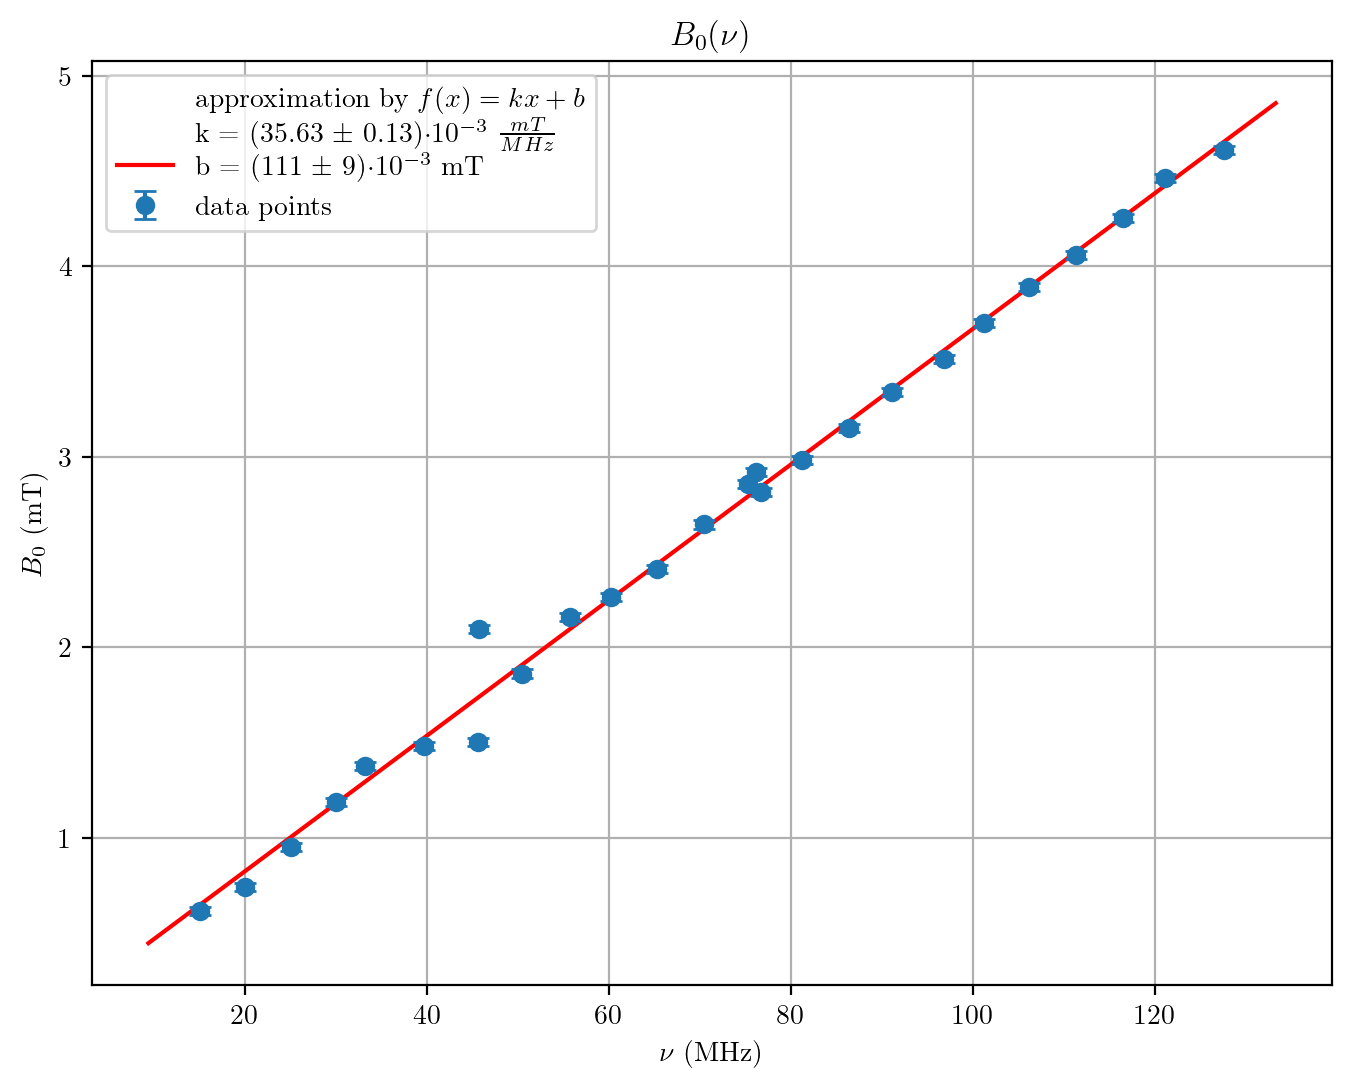

In [16]:
# making plot

# approximation
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)

# experiment measurements
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="data points", capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"{time_string()}.jpg"), dpi=300)

#### NMR experiment

In [17]:
#ВВод данных
df = pd.read_excel("Resonance.ods", engine="odf", sheet_name=1) # for "ods" tables (requires `pip install odfpy`)
# df = pd.read_excel("measurements.xls")    # for excel tables
x = df.iloc[:, 0].dropna()
y = df.iloc[:, 1].dropna()
xerr = None; np.ones_like(x)*0.01
yerr = df.iloc[:, 4].dropna()
df.head()

,glycerin,Unnamed: 1,Unnamed: 2,Unnamed: 3,Teflon,Unnamed: 5,Unnamed: 6,Polysterene(C_8 H_8),Unnamed: 8
0,I (A),v (MHz),B (mT),NaN,I (A),v (MHz),NaN,I (A),v (MHz)
1,3.1,17.1865,414,NaN,4.3,19.6,NaN,3.5,18.854
2,3.07,17.4357,414,NaN,NaN,NaN,NaN,3.6,NaN
3,3.2,17.8729,423,NaN,NaN,NaN,NaN,NaN,NaN
4,3.31,18.2187,430,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# параметры построения графика и аппроксмации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$\nu$", "MHz"
yname, yunit = r"$B_0$", "mT"
par_names_str = fr'''
k, $\frac{{{yunit.replace('$', '')}}}{{{xunit.replace('$', '')}}}$
b, {yunit}
'''
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

0.03562509418267256 +- 0.00012865150918236007
0.11136732267204494 +- 0.009930334634921243


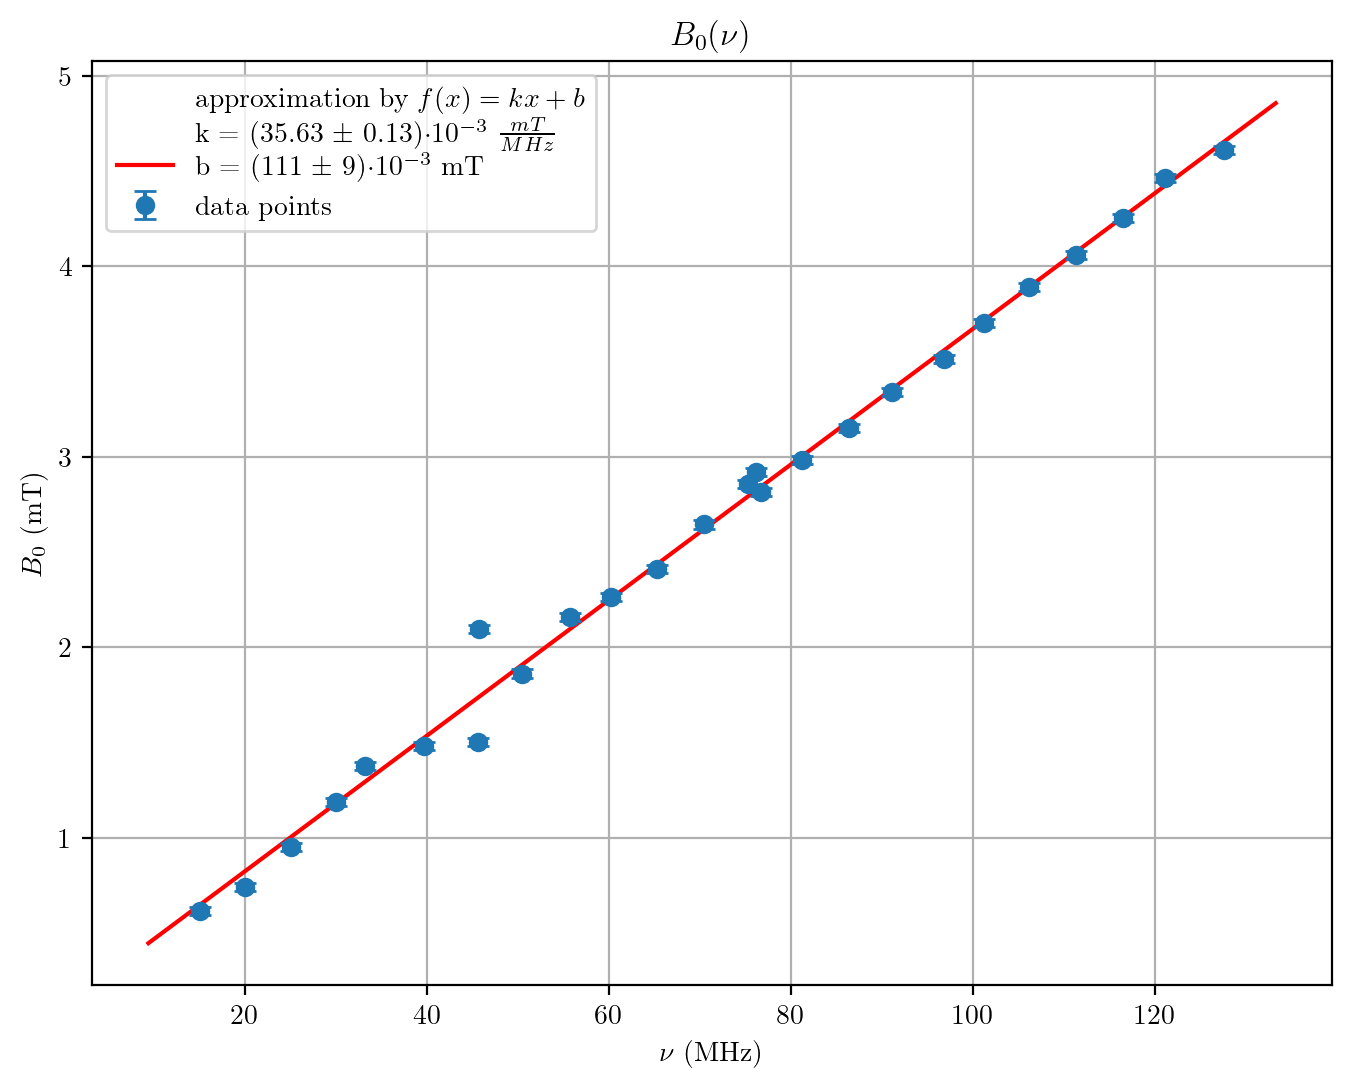

In [ ]:
# making plot

# approximation
plot_approx(x, y, f, par_names_str, fun_name, yerr=yerr, visApproxError=visApproxError)

# experiment measurements
plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="data points", capsize=4, ms=6)

make_beautiful_plot(xname, xunit, yname, yunit)

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"{time_string()}.jpg"), dpi=300)

In [20]:
# шаблон аппроксимации экспонентой
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика, 
название функции,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
xname, xunit = r"$t$", "с"
yname, yunit = r"$h$", "см"
par_names_str = fr'''
$f_0$, {yunit}
$\Delta f$, {yunit}
$T_0$, {xunit}
'''
# function to approximate
fun_name = r"$f(x) = f_0 + \Delta f e^{-x/T_0}$"
def f(x, f_0, df, T0):
    return f_0 + df*np.exp(-x/T0)
# конец пользовательских параметров
p0 = [y[0], y.max()-y.min(), (x.max()-x.min())/8]   # адекватное начальное приближение параметров

In [21]:
# параметры построения графика и аппроксмации относительно произвольной функцией
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название графика,
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k,
b,
'''
xname, xunit = r"$x$", ""
yname, yunit = r"$y$", ""
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

# Блоки для добавления в ячейку построения графика

In [22]:
# выбор поднабора для построения на графике и аппроксимации
filter = x < 15000
x = x[filter]
y = y[filter]
xerr = xerr[filter]
yerr = yerr[filter]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
# опциональная загрузка данных разных измерений
N = 0 # номер измерения
stride = 3
x = df.iloc[:, stride*N+1].dropna()
y = df.iloc[:, stride*N+0].dropna()
xerr = np.ones_like(x)*0.1
yerr = np.ones_like(x)*1
label = df.iloc[:, stride*N+stride-2].name    # если он есть, его надо добавить в label errorbar'а
xname, xunit = x.name.split(', ')
yname, yunit = y.name.split(', ')

In [ ]:
plt.xscale('log')